<a href="https://colab.research.google.com/github/dickyadem/Classification-Flowers-with-CNN-using-Tensorflow-Accuracy-95-and-validation-accuracy-85/blob/main/Classification_Flowers_with_CNN_using_Tensorflow_95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import tensorflow as tf
import zipfile,os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import seaborn as sns
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

# Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset="/content/drive/MyDrive/Colab Notebooks/flowers/flowers"
IMAGE_DIM = 150,150
CLASSES = ['daisy', 'dandelion', 'rose']
train = []

for i in CLASSES:
    path = os.path.join(dataset,i)
    idx = CLASSES.index(i)
    for img in os.listdir(path):
        if img.endswith('.jpg'):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, IMAGE_DIM)
            train.append([img_array, idx])
            
X=[] 
y=[] 
for i,j in train:
    X.append(i)
    y.append(j)




In [ ]:
X = np.array(X).reshape(-1,*IMAGE_DIM,3)/255.0

y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)

((2084, 150, 150, 3), (2084, 3), (521, 150, 150, 3), (521, 3))

In [ ]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    brightness_range=[0.6,1],
                    fill_mode = 'nearest',
                    validation_split=0.2
                    )
datagen.fit(x_train)

#Modeling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMAGE_DIM,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5, input_shape=(2,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])


# Training

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")]

opt=tf.keras.optimizers.Adam(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=METRICS)
 


In [ ]:
earlystop = EarlyStopping(monitor='loss', patience=5)

In [ ]:
EPOCHS = 40
BATCH_SIZE = 128
NUM_TRAINING_IMAGES = x_train.shape[0]
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [ ]:

history = model.fit(datagen.flow(x_train, y_train, batch_size = BATCH_SIZE),
                        epochs = EPOCHS, verbose = 1, 
                        callbacks = earlystop,
                        validation_data = (x_test,y_test),
                        steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/40
16/16 [==============================] - 25s 716ms/step - loss: 1.0284 - categorical_accuracy: 0.5854 - val_loss: 3.3854 - val_categorical_accuracy: 0.4319
Epoch 2/40
16/16 [==============================] - 11s 684ms/step - loss: 0.7283 - categorical_accuracy: 0.6933 - val_loss: 3.1187 - val_categorical_accuracy: 0.4587
Epoch 3/40
16/16 [==============================] - 11s 718ms/step - loss: 0.6564 - categorical_accuracy: 0.7336 - val_loss: 1.6252 - val_categorical_accuracy: 0.5048
Epoch 4/40
16/16 [==============================] - 12s 723ms/step - loss: 0.6159 - categorical_accuracy: 0.7459 - val_loss: 0.8526 - val_categorical_accuracy: 0.6392
Epoch 5/40
16/16 [==============================] - 11s 686ms/step - loss: 0.5805 - categorical_accuracy: 0.7699 - val_loss: 0.7710 - val_categorical_accuracy: 0.6699
Epoch 6/40
16/16 [==============================] - 11s 685ms/step - loss: 0.5361 - categorical_accuracy: 0.7904 - val_loss: 0.7546 - val_categorical_accuracy: 0.708

In [ ]:
results = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print("Validation loss, categorical_accuracy:", results)

5/5 [==============================] - 0s 48ms/step - loss: 0.6338 - categorical_accuracy: 0.8407
Validation loss, categorical_accuracy: [0.6338455677032471, 0.8406909704208374]


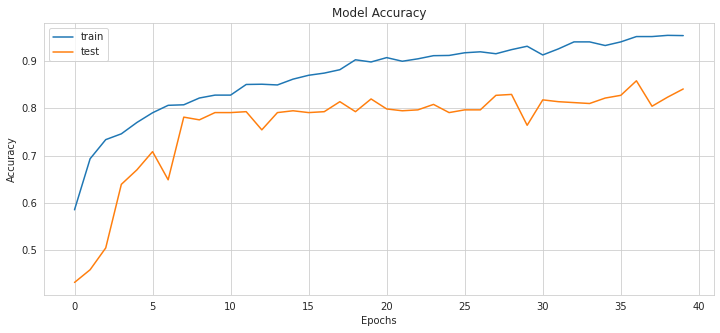

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

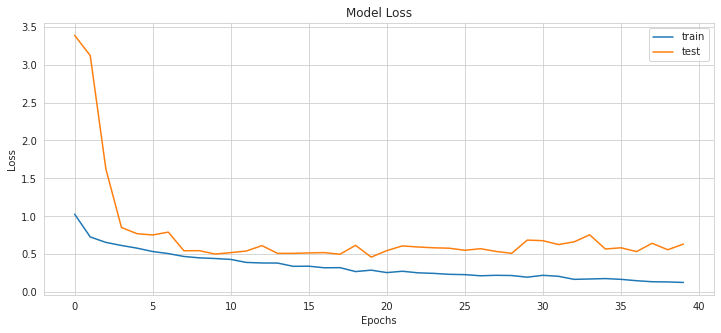

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("SavedModel_path")
tflite_model = converter.convert()
 
with tf.io.gfile.GFile('CNN.tflite', 'wb') as f:
    f.write(tflite_model)